In [731]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [732]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import ComplementNB
from sklearn.neural_network import MLPRegressor

In [733]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [734]:
query_dir = 'queries'

In [735]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [736]:
query_client = bigquery.Client()

In [737]:
request = queries['combined_analysis_data.sql']

In [738]:
data = query_client.query(request).to_dataframe()

In [739]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [740]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602 entries, 0 to 1858
Data columns (total 21 columns):
ad_id                1602 non-null int64
apt_id               855 non-null object
new_building         1602 non-null bool
num_bedrooms         1580 non-null float64
floor                1273 non-null float64
primary_size         1602 non-null float64
total_size           1546 non-null float64
price                1602 non-null float64
property_type        1602 non-null object
ownership_type       1602 non-null object
construction_year    1601 non-null float64
energy_character     753 non-null object
common_expenses      561 non-null float64
common_wealth        418 non-null float64
common_debt          536 non-null float64
time_s               1536 non-null float64
lat                  1536 non-null float64
lng                  1536 non-null float64
address              1602 non-null object
short_description    1602 non-null object
full_description     1602 non-null object
dtypes:

In [741]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,common_wealth,common_debt,time_s,lat,lng,address,short_description,full_description
0,85287718,120,True,2.0,1.0,48.0,59.0,4150000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...
1,85287718,143,True,2.0,2.0,56.0,61.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...
2,85287718,183,True,2.0,5.0,51.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...
3,85287718,187,True,2.0,5.0,48.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...
4,85287718,204,True,3.0,6.0,86.0,92.0,8495000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...


In [742]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [743]:
num_cols = ['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year', 'lat', 'lng']
cat_cols = ['new_building', 'energy_letter', 'energy_color', 'property_type', 'ownership_type']
text_cols = ['short_description', 'full_description']

In [744]:
sample_size = 5

In [745]:
data_random_one_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(sample_size)
                                                                 if len(obj) > sample_size
                                                                 else obj.sample(len(obj)))

In [746]:
num_data = data_random_one_from_new_buildings[num_cols].copy()

In [747]:
cat_data = data_random_one_from_new_buildings[cat_cols].copy()

In [748]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [749]:
text_data = data_random_one_from_new_buildings[text_cols].copy()

In [750]:
num_data['price_per_sq_m'] = num_data.price / num_data.primary_size

In [751]:
num_cat_data_corr = num_data.join(cat_data).corr()

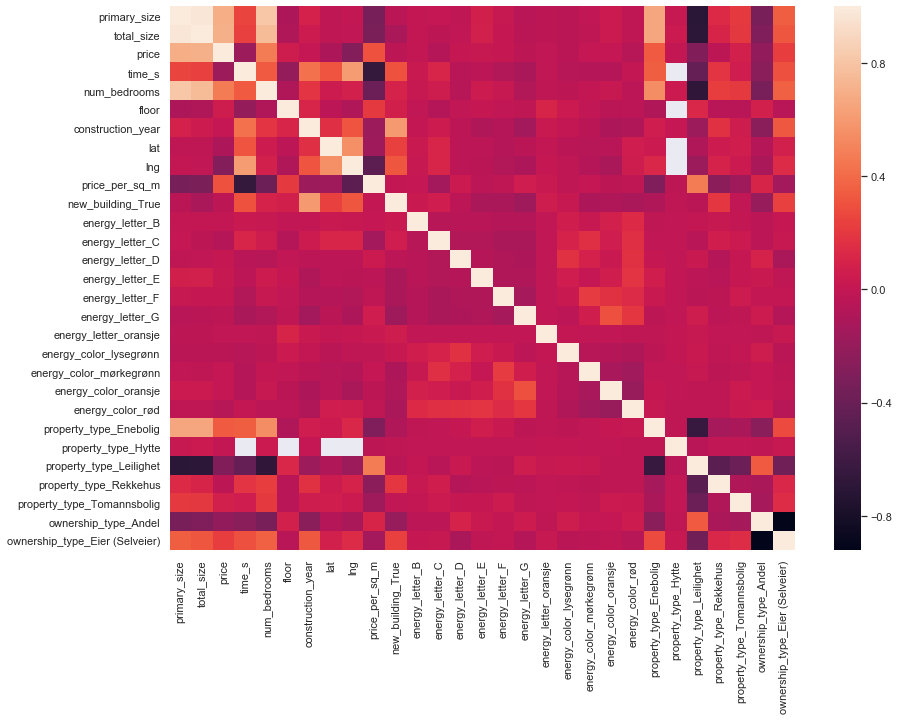

In [752]:
sns.heatmap(num_cat_data_corr)

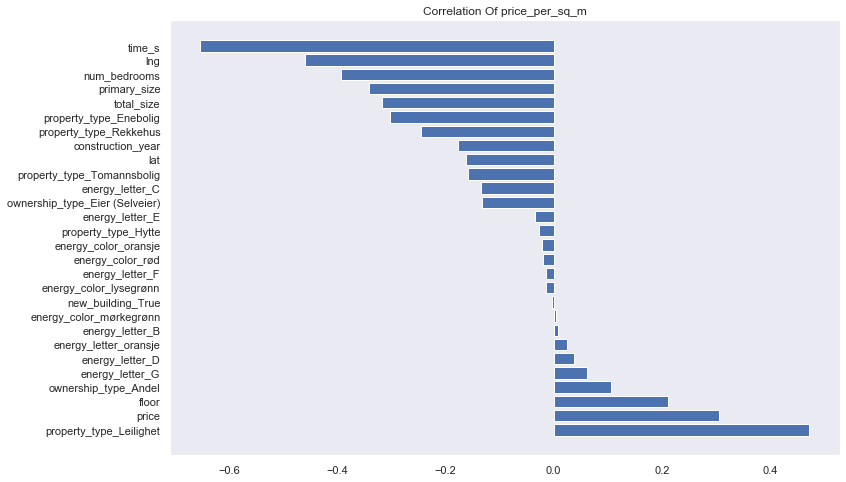

In [753]:
corr_col = 'price_per_sq_m'
to_plot = num_cat_data_corr[corr_col].drop(corr_col).sort_values(ascending=False)
f = plt.figure(figsize=(12, 8))
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title(f'Correlation Of {corr_col}')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [754]:
model_data = num_data.join(cat_data)

In [755]:
model_data.dropna(inplace=True)

In [756]:
# model_data = model_data[model_data.total_size.isin(range(45, 95))]
# model_data = model_data[model_data.price.isin(range(int(3e6), int(8e6)))]

In [757]:
model_data.describe()

,primary_size,total_size,price,time_s,num_bedrooms,floor,construction_year,lat,lng,price_per_sq_m,new_building_True,energy_letter_B,energy_letter_C,energy_letter_D,energy_letter_E,energy_letter_F,energy_letter_G,energy_letter_oransje,energy_color_lysegrønn,energy_color_mørkegrønn,energy_color_oransje,energy_color_rød,property_type_Enebolig,property_type_Hytte,property_type_Leilighet,property_type_Rekkehus,property_type_Tomannsbolig,ownership_type_Andel,ownership_type_Eier (Selveier)
count,694.000000,694.000000,6.940000e+02,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.0,694.000000,694.000000,694.000000,694.000000,694.000000
mean,82.221902,92.699568,5.395997e+06,1935.305476,2.193084,2.938040,1979.455331,59.936466,10.834952,69759.621675,0.302594,0.034582,0.072046,0.066282,0.063401,0.103746,0.132565,0.001441,0.030259,0.087896,0.136888,0.193084,0.054755,0.0,0.876081,0.036023,0.031700,0.322767,0.641210
std,41.600620,51.692447,2.827813e+06,1155.019629,0.993577,1.747534,41.504500,0.116267,0.208429,23765.092221,0.459712,0.182851,0.258751,0.248955,0.243858,0.305151,0.339348,0.037959,0.171424,0.283348,0.343977,0.395003,0.227666,0.0,0.329727,0.186482,0.175327,0.467871,0.479991
min,14.000000,16.000000,1.514691e+06,326.000000,0.000000,1.000000,1850.000000,59.502466,10.376291,17347.783784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,62.000000,3.516563e+06,1113.000000,2.000000,2.000000,1952.250000,59.914725,10.732717,49083.696970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
50%,72.000000,80.000000,4.568736e+06,1551.500000,2.000000,2.000000,1988.000000,59.926644,10.774202,69609.940382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000
75%,93.000000,104.000000,6.389677e+06,2662.250000,3.000000,4.000000,2019.000000,59.946084,10.882103,85336.145175,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,368.000000,479.000000,2.310457e+07,7715.000000,8.000000,12.000000,2019.000000,60.334302,11.569888,152294.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [758]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 694 entries, (85287718, 6) to (150469257, 1858)
Data columns (total 29 columns):
primary_size                      694 non-null float64
total_size                        694 non-null float64
price                             694 non-null float64
time_s                            694 non-null float64
num_bedrooms                      694 non-null float64
floor                             694 non-null float64
construction_year                 694 non-null float64
lat                               694 non-null float64
lng                               694 non-null float64
price_per_sq_m                    694 non-null float64
new_building_True                 694 non-null uint8
energy_letter_B                   694 non-null uint8
energy_letter_C                   694 non-null uint8
energy_letter_D                   694 non-null uint8
energy_letter_E                   694 non-null uint8
energy_letter_F                   694 non-null uint8
e

In [759]:
model_data.columns

Index(['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms',
       'floor', 'construction_year', 'lat', 'lng', 'price_per_sq_m',
       'new_building_True', 'energy_letter_B', 'energy_letter_C',
       'energy_letter_D', 'energy_letter_E', 'energy_letter_F',
       'energy_letter_G', 'energy_letter_oransje', 'energy_color_lysegrønn',
       'energy_color_mørkegrønn', 'energy_color_oransje', 'energy_color_rød',
       'property_type_Enebolig', 'property_type_Hytte',
       'property_type_Leilighet', 'property_type_Rekkehus',
       'property_type_Tomannsbolig', 'ownership_type_Andel',
       'ownership_type_Eier (Selveier)'],
      dtype='object')

In [760]:
target = 'price'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [761]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [762]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

In [763]:
selected_cols = ['primary_size', 'price', 'time_s', 'num_bedrooms',
                 'floor', 'construction_year', 'lat', 'lng',
                 'property_type_Enebolig',
                 'property_type_Hytte', 'property_type_Leilighet',
                 'property_type_Rekkehus', 'property_type_Tomannsbolig',
                 'ownership_type_Andel', 'ownership_type_Eier (Selveier)']

In [764]:
scaler = MinMaxScaler()
model_data_scaled = pd.DataFrame(scaler.fit_transform(model_data), columns=model_data.columns, index=model_data.index)

In [765]:
# model_data = model_data[selected_cols]

In [766]:
random_seed = 42
test_size = 0.25

In [767]:
X_train, X_test, y_train, y_test = train_test_split(model_data_scaled.drop(target, axis=1),
                                                    model_data_scaled[target],
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [768]:
X_train.shape

(520, 27)

In [769]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [770]:
steps = []
steps.append(('normalize', Normalizer()))
# steps.append(('scale', MinMaxScaler()))
# steps.append(('standardize', StandardScaler()))
# steps.append(('dl', KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False)))
steps.append(('ada', AdaBoostRegressor()))
# steps.append(('linear', LinearRegression()))
# steps.append(('kneighbors', KNeighborsRegressor()))
# steps.append(('bayes', ComplementNB()))
# steps.append(('mlp', MLPRegressor()))

In [771]:
pipeline = Pipeline(steps)

In [772]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('normalize', Normalizer(copy=True, norm='l2')),
                ('ada',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=None))],
         verbose=False)

In [773]:
pred = pipeline.predict(X_test)

In [774]:
y_pred = pd.Series(pred, index=X_test.index, name='predicted')

In [775]:
data_and_pred = X_test.join(y_pred)
inverse_scaled_res = pd.DataFrame(scaler.inverse_transform(data_and_pred),
                                  columns=data_and_pred.columns,
                                  index=data_and_pred.index).join(model_data[target], how='left')

inverse_scaled_res = inverse_scaled_res[['predicted', target]]

In [776]:
inverse_scaled_res.head()

,,predicted,price
ad_id,,,
149502637,1261,8.330420e+06,7452400.0
150365877,1819,4.560483e+06,3602149.0
146667253,1045,8.125333e+06,4839722.0
149430372,1207,4.600801e+06,3328175.0
149262846,1167,9.404126e+06,11313722.0


In [777]:
unscaled_error = mean_absolute_error(inverse_scaled_res[target], inverse_scaled_res['predicted'])
print(f'The unscaled mae is: {unscaled_error:.0f}')

The unscaled mae is: 1073071


In [778]:
scaled_error = mean_absolute_error(y_test, y_pred)
print(f'The mae is: {scaled_error:.1%}')

The mae is: 5.0%


In [779]:
train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [780]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [781]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

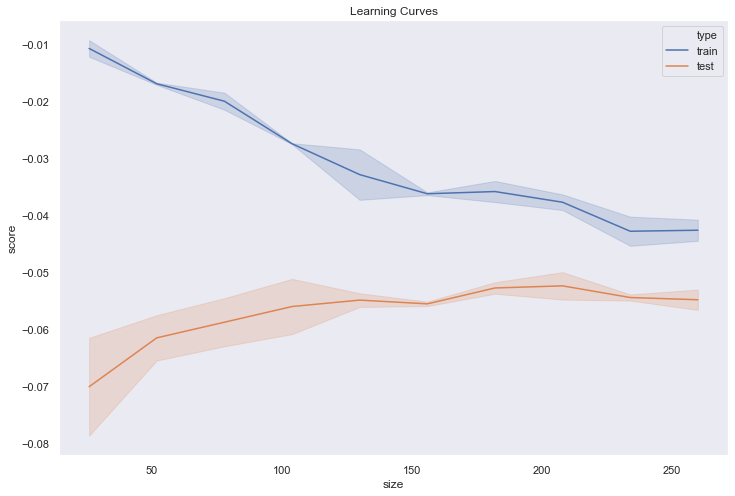

In [782]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)